# Homework #3

## Load Data

In [2]:
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import cv2
import pandas as pd
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras import regularizers
from keras.utils import np_utils

# Size the plot appropriately for online display
plt.rcParams['figure.figsize'] = (16.0, 12.0)

nr.seed(3244)

x_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('X_test.npy')


def imageResize(img):
    return cv2.resize(img, (0,0), fx=3, fy=3)

# Reshape
X_train = x_train.reshape(x_train.shape[0], 50, 37)
X_test = x_test.reshape(x_test.shape[0], 50, 37)

# Resize
# X_train = np.asarray(list(map(imageResize, x_train_reshaped)))
# X_test = np.asarray(list(map(imageResize, x_test_reshaped)))

N, HEIGHT, WIDTH = X_train.shape

Using TensorFlow backend.


# Image Preprocessing Utilities

In [ ]:
# Format output file
def saveOutput(y_test):
    df = pd.DataFrame(y_test,columns=['PredictedClass'])
    df['Imageid']=np.arange(len(df))
    df.to_csv('y_test.csv',index=False)

In [ ]:
def imageFilter(img, kernel):
    kernel = np.array(kernel,np.int32)/25
    return cv2.filter2D(img,-1,kernel)

In [ ]:
def gaussianBlur(img):
    return cv2.GaussianBlur(img,(5,5),0)

In [ ]:
def sharpen(img):
    kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]],np.int32)/25
    return cv2.filter2D(img,-1,kernel)

In [ ]:
def unsharpMask(img):
    gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
    return cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)

### Test Image

In [ ]:
testImg = X_train[543]
plt.axis('off')
plt.imshow(testImg)

In [ ]:
# Sobel Filter

def sobelFilter(imageArray):
    sobelHorizontal = imageFilter(imageArray, [[3,10,3],[0,0,0],[-3,-10,-3]])
    sobelVertical = imageFilter(imageArray, [[-3,0,3],[-10,0,10],[-3,0,3]])
    
    sobel = np.empty([HEIGHT, WIDTH])
    for i in range (0, HEIGHT):
        for j in range (0, WIDTH):
            sobel[i][j] = (sobelHorizontal[i][j]**2 + sobelVertical[i][j]**2)**(1/2)
            
    return sobel

sobel = sobelFilter(testImg)
plt.axis('off')
plt.imshow(sobel)

In [ ]:
# Sobel Filter 2D
import math

def sobelFilter2D(imageArray):
    sobelx = cv2.Sobel(imageArray,cv2.CV_64F,1,0,ksize=3)
    sobely = cv2.Sobel(imageArray,cv2.CV_64F,0,1,ksize=3)
    sobel = np.empty([HEIGHT, WIDTH, 2])
    for i in range (0, HEIGHT):
        for j in range (0, WIDTH):
            sobel[i][j][0] = (sobelx[i][j]**2 + sobely[i][j]**2)**(1/2)
            sobel[i][j][1] = np.arctan(sobely[i][j] / sobelx[i][j])
            if math.isnan(sobel[i][j][1]): sobel[i][j][1] = 0
    return sobel

In [ ]:
# canny Filter

def cannyFilter(imageArray):
    imageArrayCopy = np.uint8(imageArray)
    img = cv2.Canny(imageArrayCopy,10,50)
    
    return img

img = cannyFilter(testImg)
plt.axis('off')
plt.imshow(img)

# CNN MODEL

In [ ]:
def cnn(X_train, y_train, X_test, image_shape):
    HEIGHT, WIDTH, DIMENSION = image_shape
    # Reshape
    X_train = X_train.reshape(X_train.shape[0], HEIGHT, WIDTH, DIMENSION)
    X_test = X_test.reshape(X_test.shape[0], HEIGHT, WIDTH, DIMENSION)

    # Normalize
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255

    # Convert label to categorical matrix
    Y_train = np_utils.to_categorical(y_train, 7)

    # Declare Sequential model
    model = Sequential()

    # CNN model architecture
    model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, DIMENSION)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(7, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    # Fit model
    model.fit(X_train, Y_train,
              validation_split=0.5, shuffle=True,
              batch_size=42, epochs=1, verbose=1)
    
    # Evaluate train data
    score = model.evaluate(X_train, Y_train, verbose=1)
    print()
    print("Train Accuracy: " + str(score[1]))
    print()
    
    # Predict test data
    prediction = model.predict(X_test, verbose=1)
    
    # Get output for test data
    y_test = map(np.argmax, prediction)
    y_test = np.asarray(list(y_test))
    print("Test output")
    print(y_test)
    print(y_test.shape)
    
    return y_test

## VANILLA IMAGES

In [ ]:
y_test = cnn(X_train, y_train, X_test, (HEIGHT, WIDTH, 1))

In [ ]:
saveOutput(y_test)

## SOBEL FILTERED IMAGES version 1

In [ ]:
# Apply sobel filter
X_train_sobel = np.asarray(list(map(sobelFilter, X_train)))
X_test_sobel = np.asarray(list(map(sobelFilter, X_test)))

y_test = cnn(X_train_sobel, y_train, X_test_sobel, (HEIGHT, WIDTH, 1))

In [ ]:
saveOutput(y_test)

## SOBEL FILTERED IMAGES version 2

In [ ]:
# Apply 2D sobel filter
X_train_sobel2D = np.asarray(list(map(sobelFilter2D, X_train)))
X_test_sobel2D = np.asarray(list(map(sobelFilter2D, X_test)))

y_test = cnn(X_train_sobel2D, y_train, X_test_sobel2D, (HEIGHT, WIDTH, 2))

In [ ]:
saveOutput(y_test)

## CANNY FILTERED IMAGES

In [ ]:
# Apply canny filter
X_train_canny = np.asarray(list(map(cannyFilter, X_train)))
X_test_canny = np.asaveOutput(y_test)sarray(list(map(cannyFilter, X_test)))

y_test = cnn(X_train_canny, y_train, X_test_canny, (HEIGHT, WIDTH, 1))

In [ ]:
saveOutput(y_test)

# Bayesian Optimization Hyperparameter Tuning

In [ ]:
from bayes_opt import BayesianOptimization

# Reshape to 1 dimension
X_train_vanilla = X_train.reshape(X_train.shape[0], HEIGHT, WIDTH, 1)
X_test_vanilla = X_test.reshape(X_test.shape[0], HEIGHT, WIDTH, 1)

# Normalize
X_train_vanilla = X_train_vanilla.astype('float32')
X_test_vanilla = X_test_vanilla.astype('float32')
X_train_vanilla /= 255
X_test_vanilla /= 255

# Change to categorical matrix
Y_train_vanilla = np_utils.to_categorical(y_train, 7)

# Split to train set and validation set
X_train_original = X_train_vanilla[:700]
Y_train_original = Y_train_vanilla[:700]

X_validate = X_train_vanilla[700:]
Y_validate = Y_train_vanilla[700:]

def cnn(drop_rate1, drop_rate2, dense_size, batch_size, epochs):
    dense = int(dense)
    batch_size = int(batch_size)
    epochs = int(epochs)
    
    # Declare Sequential model
    model = Sequential()

    # CNN model architecture
    model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(HEIGHT, WIDTH, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(drop_rate1))

    model.add(Flatten())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(drop_rate2))
    model.add(Dense(7, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Fit model
    model.fit(X_train_original, Y_train_original, 
              batch_size=batch_size, epochs=epochs, verbose=1)
    
    # Evaluate with validation set
    score = model.evaluate(X_validate, Y_validate, verbose=1)
    return score[1]

bo = BayesianOptimization(cnn,
            {'drop_rate1': (0, 1), 'drop_rate2': (0, 1), 'dense_size': (7, 8192), 'batch_size': (8, 128), 'epochs': (3, 50)})

bo.maximize(init_points=5, n_iter=100, acq='ucb', kappa=5)

# Visualization of model architecture

### Additional libraries needed for below: pydot,graphviz,viz(https://github.com/raghakot/keras-vis)

In [3]:
# for plotting and exporting model diagrams
from keras.utils import plot_model
import pydot,graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from vis.visualization import visualize_saliency, overlay,visualize_cam
from vis.utils import utils
from keras import activations
import matplotlib.cm as cm

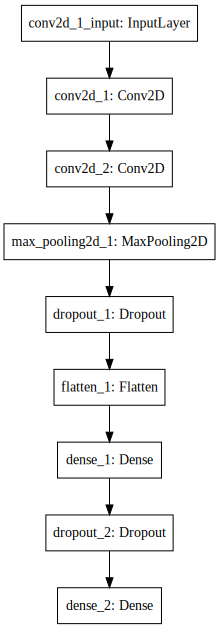

In [6]:
# uncommet this line to export the image
# plot_model(model, to_file='sobel model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Visualization of the FC layer activation

#### Train the model first before this visualization

In [ ]:
# For original image trained model

# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_2')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, seed_input=X_train_vanilla[2]) # can choose any number
# Plot with 'jet' colormap to visualize as a heatmap.
plt.imshow(grads, cmap='jet')

In [ ]:
# For sobel image trained model

layer_idx = -1 # or utils.find_layer_idx(model, 'dense_2')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

seen = []
# This corresponds to the Dense linear layer.
for image_idx in np.arange(100):  
    class_idx = int(np.where(Y_train[image_idx]==1)[0])    
    if class_idx in seen:
        continue       
    else:
        seen.append(class_idx)
    if len(seen)==7:
        break
    
    f, ax = plt.subplots(1, 4)
    ax[0].imshow(X_train_sobel[image_idx][:,:,0])
    ax[0].set_title('original')
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=X_train_sobel[image_idx], backprop_modifier=modifier)
    
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(grads, cmap='jet')
        
        plt.savefig('class'+str(class_idx)+'_sobel.png')